In [18]:
import pandas as pd
import requests
import xml.etree.ElementTree as ET
from sklearn.metrics import accuracy_score

In [2]:
def load_xml_from_url(url: str) -> pd.DataFrame:
    r = requests.get(url)

    root = ET.fromstring(r.text)
    records = root.find('records') 

    def extract(child):
        parts = []
        for sub in child:
            if len(sub) != 0:
                parts.append(extract(sub))
                continue

            if sub.tag.lower() in ('_face','_font','_size'):
                continue

            if sub.text and sub.text.strip():
                parts.append(sub.text.strip())
        text = ','.join(parts)

        return text

    rows = []
    for rec in records.findall('record'):
        row = {}
        for child in rec:
            text = ''
            tag = child.tag
            if len(child) == 0:
                text = (child.text or '').strip()
            else:
                text = extract(child)

            row[tag] = text
        rows.append(row)

    return pd.DataFrame(rows)

In [5]:
url = 'https://raw.githubusercontent.com/IEBH/dedupe-sweep/master/test/data/tafenoquine.xml'

df_tafenoquine = load_xml_from_url(url)
df_tafenoquine['label'] = df_tafenoquine['caption'].apply(lambda x: 1 if x == 'Duplicate' else 0)

df_tafenoquine.columns

Index(['database', 'source-app', 'rec-number', 'foreign-keys', 'ref-type',
       'contributors', 'auth-address', 'titles', 'periodical', 'volume',
       'number', 'edition', 'keywords', 'dates', 'isbn', 'accession-num',
       'abstract', 'notes', 'urls', 'custom2', 'electronic-resource-num',
       'remote-database-provider', 'language', 'pages', 'work-type', 'custom1',
       'remote-database-name', 'custom5', 'caption', 'custom3', 'custom7',
       'alt-periodical', 'custom4', 'label'],
      dtype='object')

## Computing Jaccard similarity

*Jaccard similarity* of two sets $A$ and $B$ is typicallly defined by the following formula

$$
J(A, B) = \frac{|A \cap B|}{|A \cup B|}.
$$

In order to use it for string comparison, we need to somehow represent the string, which is an ordered sequence of characters,
as a set. We will do that by computing n-grams, which for this algorithms purposes, will be a set of all n-length character
sequences that occur within analyzed text.

In [6]:
def find_ngrams(text: str, n: int):
    return [text[i:i + n] for i in range(len(text) - n + 1)]

find_ngrams('apple', 2)

['ap', 'pp', 'pl', 'le']

In [7]:
def jaccard_similarity(a: str, b: str) -> float:
    a_ngrams = set(find_ngrams(a, 2))
    b_ngrams = set(find_ngrams(b, 2))

    intersection = a_ngrams.intersection(b_ngrams)
    union = a_ngrams.union(b_ngrams)

    return len(intersection) / len(union) if len(union) != 0 else 0

print(jaccard_similarity('apple', 'apples'))
print(jaccard_similarity('apple', 'apap'))
print(jaccard_similarity('apple', 'giraffe'))

long_strings = (
"Reasumując wszystkie aspekty kwintesencji tematu, dochodzę do fundamentalej konkluzji - warto studiować.",
"No hejka, co tam się z Tobą dzieje? Skąd to zwątpienie? Dlaczego chcesz teraz się poddać, tylko dlatego, że raz czy drugi Ci nie wyszło? To nie jest żaden powód. Musisz iść i walczyć. Osiągniesz cel. Prędzej czy później go osiągniesz, ale musisz iść do przodu, przeć, walczyć o swoje. Nie ważne, że wszystko dookoła jest przeciwko Tobie. Najważniejsze jest to, że masz tutaj wole zwycięstwa. To się liczy. Każdy może osiągnąć cel, nie ważne czy taki czy taki, ale trzeba iść"
)

print(jaccard_similarity(*long_strings))

0.8
0.2
0.0
0.18473895582329317


In [8]:
from typing import List
import numpy as np

def compare_records(rec1: List[str], rec2: List[str]):
    scores = [jaccard_similarity(a, b) for a, b in zip(rec1, rec2) if not pd.isna(a) and not pd.isna(b)]
    return np.mean(scores)

def extract_interesting_strings(series: pd.Series) -> List[str]:
    return series[["titles", "contributors", "periodical", "abstract"]].tolist()

# Unrelated records
print(compare_records(
    extract_interesting_strings(df_tafenoquine.iloc[0]),
    extract_interesting_strings(df_tafenoquine.iloc[1])
))

# Actual duplicates
print(compare_records(
    extract_interesting_strings(df_tafenoquine.iloc[8]),
    extract_interesting_strings(df_tafenoquine.iloc[9])
))


0.21650083064251954
0.6970957130335017


In [9]:
import itertools

def find_duplicate_records(df: pd.DataFrame, threshold: float = 0.6) -> List[tuple]:
    duplicates = []
    for (s1_idx, s1), (s2_idx, s2) in itertools.combinations(df.iterrows(), 2):
        score = compare_records(
            extract_interesting_strings(s1),
            extract_interesting_strings(s2)
        )
        
        if score > threshold:
            duplicates.append((s1_idx, s2_idx, score))
    return duplicates

duplicates = find_duplicate_records(df_tafenoquine)

In [10]:
def deduplication_results(df: pd.DataFrame, threshold: float) -> tuple:
    duplicates = find_duplicate_records(df, threshold=threshold)
    y_true = df['label']
    y_pred = [0] * len(y_true)
    for s1_idx, s2_idx, _ in duplicates:
        y_pred[s1_idx] = 1
        y_pred[s2_idx] = 1
    return y_true, y_pred

In [11]:
from sklearn.metrics import accuracy_score

accuracies = []
thresholds = list(np.linspace(0.5, 1.0))
for threshold in thresholds:
    y_true, y_pred = deduplication_results(df_tafenoquine, threshold=threshold)
    accuracy = accuracy_score(y_true, y_pred)
    accuracies.append(accuracy)

In [13]:
import pickle

with open("threshold_search_results.pkl", "wb") as f:
    pickle.dump((thresholds, accuracies), f)

In [14]:
import pickle

with open("threshold_search_results.pkl", "rb") as f:
    thresholds, accuracies = pickle.load(f)

Text(0, 0.5, 'Accuracy')

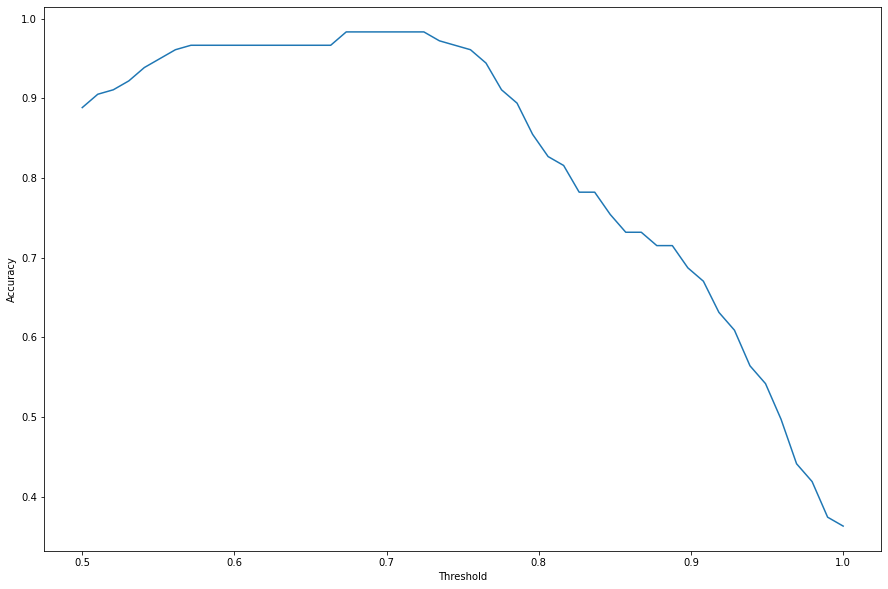

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.plot(thresholds, accuracies)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')

In [15]:
idx_max = np.argmax(accuracies)
threshold = thresholds[idx_max]

print(f"Max accuracy: {accuracies[idx_max]} achieved at threshold {threshold}")

Max accuracy: 0.9832402234636871 achieved at threshold 0.673469387755102


In [ ]:
url = 'https://raw.githubusercontent.com/IEBH/dedupe-sweep/master/test/data/uti.xml'

df_uti = load_xml_from_url(url)
df_uti['label'] = df_uti['caption'].apply(lambda x: 1 if x == 'Duplicate' else 0)

y_true, y_pred = deduplication_results(df_uti, threshold=threshold)
accuracy = accuracy_score(y_true, y_pred)
print(accuracy)

NameError: name 'accuracy_score' is not defined

In [ ]:
url = 'https://raw.githubusercontent.com/IEBH/dedupe-sweep/master/test/data/diabetes.xml'

df_diabetes = load_xml_from_url(url)
df_diabetes['label'] = df_diabetes['caption'].apply(lambda x: 1 if x == 'Duplicate' else 0)
df_diabetes = df_diabetes.dropna(subset=['abstract'])

y_true, y_pred = deduplication_results(df_diabetes, threshold=threshold)
accuracy = accuracy_score(y_true, y_pred)
print(accuracy)

In [ ]:
url = 'https://raw.githubusercontent.com/IEBH/dedupe-sweep/master/test/data/copper.xml'

df_copper = load_xml_from_url(url)
df_copper['label'] = df_copper['caption'].apply(lambda x: 1 if x == 'Duplicate' else 0)
df_copper = df_copper.dropna(subset=['abstract'])

y_true, y_pred = deduplication_results(df_copper, threshold=threshold)
accuracy = accuracy_score(y_true, y_pred)
print(accuracy)

In [ ]:
url = 'https://raw.githubusercontent.com/IEBH/dedupe-sweep/master/test/data/blue-light.xml'

df_blue_light = load_xml_from_url(url)
df_blue_light['label'] = df_blue_light['caption'].apply(lambda x: 1 if x == 'Duplicate' else 0)
df_blue_light = df_blue_light.dropna(subset=['abstract'])

y_true, y_pred = deduplication_results(df_copper, threshold=threshold)
accuracy = accuracy_score(y_true, y_pred)
print(accuracy)